In [6]:
    # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import pickle
import string

import nltk
from nltk.stem import PorterStemmer

In [7]:
data = pd.read_csv('Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


# Let's process the data

In [8]:
data.shape

(232074, 3)

    The given dataset contain more than 2 lakh rows.

    It takes take significant time and resources, as it involves optimizing the parameters of the model and processing the data iteratively.

    So I will take 10000 data points which will help to reduce complexity.


In [9]:
df = data.sample(n=20000, random_state=42)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 74414 to 89712
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20000 non-null  int64 
 1   text        20000 non-null  object
 2   class       20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 625.0+ KB


In [11]:
df['Unnamed: 0'].is_unique #Check for duplicate serial/entry

True

In [12]:
df.drop(columns = 'Unnamed: 0',inplace=True)

In [13]:
df.head()

,text,class
74414,I Don't know?7? Months self harm free and the ...,suicide
149516,I HAVE TO START BECOMING RICH I HAVE TO START ...,non-suicide
12484,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",non-suicide
14043,I've honestly got no idea what to do anymore.I...,suicide
30673,Do you ever just cry? Like you just think abou...,non-suicide


In [14]:
df.isnull().sum()

text     0
class    0
dtype: int64

In [15]:
df.duplicated().sum() # No duplicates

0

# Data Visualisation

class
non-suicide    10098
suicide         9902
Name: count, dtype: int64


([<matplotlib.patches.Wedge at 0x309bb0460>,
 [Text(-0.016932441822829075, 1.0998696706491713, 'non-suicide'),
  Text(0.01693233884559798, -1.099869672234496, 'suicide')],
 [Text(-0.009235877357906768, 0.5999289112631843, '50%'),
  Text(0.009235821188507987, -0.5999289121279069, '50%')])

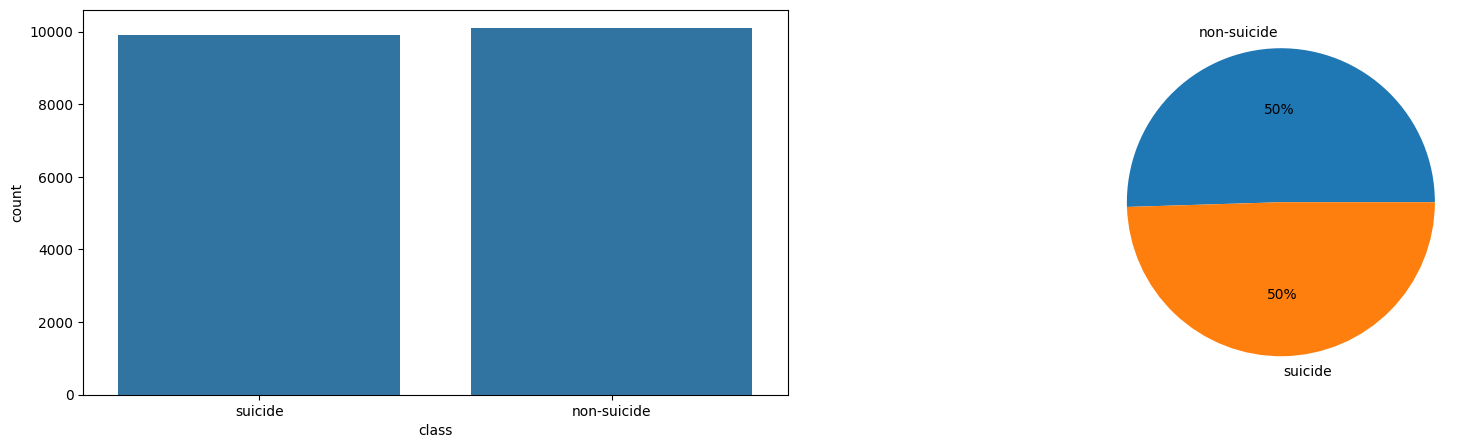

In [17]:
class_count = df['class'].value_counts()
print(class_count)

plt.figure(figsize=((20,5)))

plt.subplot(1, 2, 1)
sns.countplot(df, x='class')

plt.subplot(1, 2, 2)
plt.pie(class_count, labels=class_count.index, autopct='%.0f%%')


    Text Preprocessing
Lowering the Text
Changing the case involves converting all text to lowercase or uppercase so that all word strings follow a consistent format.
Lowercasing is the more frequent choice in NLP software.

In [18]:
df['text']= df['text'].str.lower()

# Remove Punctuations
- Text preprocessing involves various techniques to clean and transform raw text data into a more suitable format for analysis.
- Removing punctuation is one of the most commonly used preprocessing techniques, as punctuation marks do not usually add much semantic value to the text and can interfere with downstream NLP tasks.
- String library of Python contains some pre-defined list of punctuations such as ‘!”#$%&'()*+,-./:;?@[]^_`{|}~’

In [19]:
df['text'] = df['text'].str.replace(r'[^\w\s]+', '',regex = True)


In [20]:
df.head() #Lowered and punctuation removed

,text,class
74414,i dont know7 months self harm free and the urg...,suicide
149516,i have to start becoming rich i have to start ...,non-suicide
12484,a poem haiku for umegamedev hi hello hello\nst...,non-suicide
14043,ive honestly got no idea what to do anymoreit ...,suicide
30673,do you ever just cry like you just think about...,non-suicide


# Stop word removal
- Stopwords are the most commonly occurring words in a language, such as "the", "and", "a", "an", "in", "to", etc.
- These words have very little semantic value and are often used to connect meaningful words in a sentence.
- In many natural language processing (NLP) tasks, stopwords can be removed without affecting the meaning of the text, and doing so can actually improve the performance of the NLP models.

In [21]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Tokenization
- The tokenization stage involves converting a sentence into a stream of words, also called “tokens.”
- Tokens are usually words, but they can also be phrases, symbols, or other meaningful units of text.

In [22]:
df['text'] = df['text'].apply(lambda x:nltk.word_tokenize(x))


# Stemming
- The term word stem is borrowed from linguistics and used to refer to the base or root form of a word.
- Stemming is the process of converting all words to their base form, or stem.

In [23]:
ps = PorterStemmer()
df['text'] = df['text'].apply(lambda x: [ps.stem(i) for i in x])


In [24]:
df['text'] = df['text'].apply(lambda x: ' '.join(x))

In [25]:
df.head()

,text,class
74414,dont know7 month self harm free urg get strong...,suicide
149516,start becom rich start compani becom 16 afford...,non-suicide
12484,poem haiku umegamedev hi hello hello stop fuck...,non-suicide
14043,ive honestli got idea anymoreit feel everyon f...,suicide
30673,ever cri like think unfair life cri cant cri e...,non-suicide


In [26]:
# Saved the cleaned dataset.
df.to_csv('../models/file1.csv')

In [27]:
dfnew = pd.read_csv('../models/file1.csv')
dfnew.head()

,Unnamed: 0,text,class
0,74414,dont know7 month self harm free urg get strong...,suicide
1,149516,start becom rich start compani becom 16 afford...,non-suicide
2,12484,poem haiku umegamedev hi hello hello stop fuck...,non-suicide
3,14043,ive honestli got idea anymoreit feel everyon f...,suicide
4,30673,ever cri like think unfair life cri cant cri e...,non-suicide


In [28]:
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20000 non-null  int64 
 1   text        19995 non-null  object
 2   class       20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


In [29]:
ind = dfnew[dfnew['text'].isnull()].index
df.iloc[ind]


,text,class
102482,,suicide
205215,,non-suicide
11476,,non-suicide
181086,,non-suicide
216154,,non-suicide


In [30]:
dfnew.dropna(inplace=True)
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19995 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  19995 non-null  int64 
 1   text        19995 non-null  object
 2   class       19995 non-null  object
dtypes: int64(1), object(2)
memory usage: 624.8+ KB


# Machine Learning - Model Selection

In [31]:
x, y = dfnew['text'], dfnew['class']

TF-IDF Vectorizer

In [32]:
vectorizer = TfidfVectorizer(min_df=50, max_features=5000)
x = vectorizer.fit_transform(x).toarray()


In [33]:
#save the model
with open('../models/tfidf.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [34]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=5)

In [35]:
X_train.shape,X_test.shape

((13996, 2016), (5999, 2016))

Naive Bayes Voting Classifier

In [36]:
nb = GaussianNB()
nb2 = BernoulliNB()
nb3 = MultinomialNB()

VotingClassifiers = VotingClassifier(estimators=[('GaussianNB', nb), ('BernoulliNB', nb2),
                                                 ('MultinomialNB', nb3)], voting='soft')

VotingClassifiers.fit(X_train, y_train)

print('Training score:',VotingClassifiers.score(X_train, y_train))
print('Testing score:',VotingClassifiers.score(X_test,y_test))

Training score: 0.902900828808231
Testing score: 0.8761460243373895


              precision    recall  f1-score   support

 non-suicide       0.87      0.88      0.88      3053
     suicide       0.88      0.87      0.87      2946

    accuracy                           0.88      5999
   macro avg       0.88      0.88      0.88      5999
weighted avg       0.88      0.88      0.88      5999



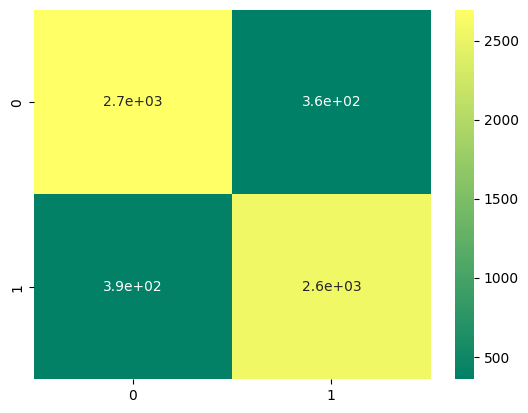

In [37]:
y_act=y_test
y_pred=VotingClassifiers.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='summer')
print(classification_report(y_act,y_pred))

In [38]:
with open('../models/best_model.pkl', 'wb') as f:
    pickle.dump(VotingClassifiers, f)    

In [39]:
def preprocess(inp):
    inp = inp.lower() #convert to lower case 
    inp = inp.replace(r'[^\w\s]+', '') #remove punctuations
    inp = [word for word in inp.split() if word not in (stop_words)] #tokenize the sentence
    inp = ' '.join([ps.stem(i) for i in inp]) #stremming
    inputToModel = vectorizer.transform([inp]).toarray() #transform to vector form
    return inputToModel

In [40]:
def app(input_text):
    # Define the input text box
    print('Input : ',input_text) #take input from user
    processed_array = preprocess(input_text) #preprocess the text 
    predict = VotingClassifiers.predict(processed_array) #Model prediction
    probabilities = VotingClassifiers.predict_proba(processed_array) # Get probability estimates
    print('Probability Estimates : ', probabilities) # Predict Probabilities
    print('Output : ', predict[0])

In [41]:
app("It's strange when I'm thinking and have many things to say but while writing it's all feel distorted. Life , I feel like I have never lived expect some months in my post graduation. The person excerpted me as I am. I told her everything even about my social Anxiety which is curse of my life. I still remember the moment she hold my hand tightly to calm me down while my body was shaking due to anxiety. After sometimes it ended. I have no hard feelings against her and very grateful to her for good times I had. Now comes to main problem. I felt like facing my fear, people, it will become easier.but nah it's even harder. Suicide feels easier than facing a class full of students. I I feel like committing suicide daily. But fear of surviving suicide is even stronger. I wish I would never woke up when I go to sleep or will die in accident. I can't share these things with anyone but I get some relief when I put these feelings in words or share with anyone. The thing I want to live and at the same time die but not committing suicide.")

Input :  It's strange when I'm thinking and have many things to say but while writing it's all feel distorted. Life , I feel like I have never lived expect some months in my post graduation. The person excerpted me as I am. I told her everything even about my social Anxiety which is curse of my life. I still remember the moment she hold my hand tightly to calm me down while my body was shaking due to anxiety. After sometimes it ended. I have no hard feelings against her and very grateful to her for good times I had. Now comes to main problem. I felt like facing my fear, people, it will become easier.but nah it's even harder. Suicide feels easier than facing a class full of students. I I feel like committing suicide daily. But fear of surviving suicide is even stronger. I wish I would never woke up when I go to sleep or will die in accident. I can't share these things with anyone but I get some relief when I put these feelings in words or share with anyone. The thing I want to live and 

In [42]:
app("Have a happy coding day!")

Input :  Have a happy coding day!
Probability Estimates :  [[0.96180058 0.03819942]]
Output :  non-suicide
